CODE BLOCK: 1


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2


In [2]:

# CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


CODE BLOCK: 3


In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=(0.1307,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4


In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 100346133.92it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24772125.53it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33473816.81it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19639720.38it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5


In [5]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

len(train_loader)

469

CODE BLOCK: 6


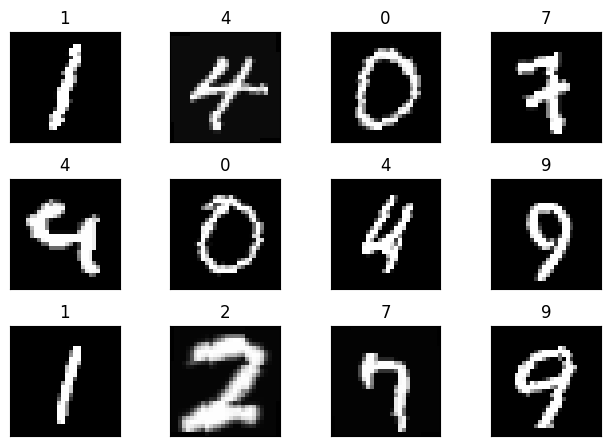

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7


In [8]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        drop = 0.025

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(drop)
        ) # output_size = 26    RF:  2

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop)
        ) # output_size = 24 RF: 5



        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6
        self.trans1 = nn.Sequential( #Antman
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # output_size = 12    RF:  6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8    RF: 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6    RF: 18
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(drop)
        )

        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)
        ) # output_size = 1  RF:  28

        #Optional Fully Connected Layer - Commenting out the fc1 and testing with 2 Conv layers as this gave a better result with less parameters
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # output_size = 1    RF: 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # output  RF: 28
        )
        # self.fc1 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = self.convblock5(x)
        x = x.view(-1, 10)   # convert 2D to 1D

        return F.log_softmax(x, dim=-1)

In [9]:
model = Net4().to(device)

In [10]:
from torchsummary import summary
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
      BatchNorm2d-12            [-1, 8, 12, 12]              16
           Conv2d-13           [-1, 12, 10, 10]             864
             ReLU-14           [-1, 12,

CODE BLOCK: 8


In [11]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9


In [12]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10


In [13]:
# model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 17

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0631 Batch_id=468 Accuracy=89.79: 100%|██████████| 469/469 [00:45<00:00, 10.42it/s]


Test set: Average loss: 0.0005, Accuracy: 9824/10000 (98.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0264 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:42<00:00, 11.03it/s]


Test set: Average loss: 0.0003, Accuracy: 9868/10000 (98.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0560 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:43<00:00, 10.82it/s]


Test set: Average loss: 0.0002, Accuracy: 9911/10000 (99.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0662 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]


Test set: Average loss: 0.0002, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0972 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:44<00:00, 10.63it/s]


Test set: Average loss: 0.0002, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.0089 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:43<00:00, 10.87it/s]


Test set: Average loss: 0.0002, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0356 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:43<00:00, 10.66it/s]


Test set: Average loss: 0.0002, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0858 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:43<00:00, 10.86it/s]


Test set: Average loss: 0.0002, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0670 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:43<00:00, 10.67it/s]


Test set: Average loss: 0.0002, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0436 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Test set: Average loss: 0.0001, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 11


Train: Loss=0.0365 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:43<00:00, 10.76it/s]


Test set: Average loss: 0.0001, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 12


Train: Loss=0.0152 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Test set: Average loss: 0.0002, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0183 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s]


Test set: Average loss: 0.0002, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0419 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:43<00:00, 10.66it/s]


Test set: Average loss: 0.0001, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0886 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Test set: Average loss: 0.0001, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 16


Train: Loss=0.0167 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:42<00:00, 11.12it/s]


Test set: Average loss: 0.0001, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 17


Train: Loss=0.0510 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]


Test set: Average loss: 0.0001, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-05.


CODE BLOCK: 11


Text(0.5, 1.0, 'Test Accuracy')

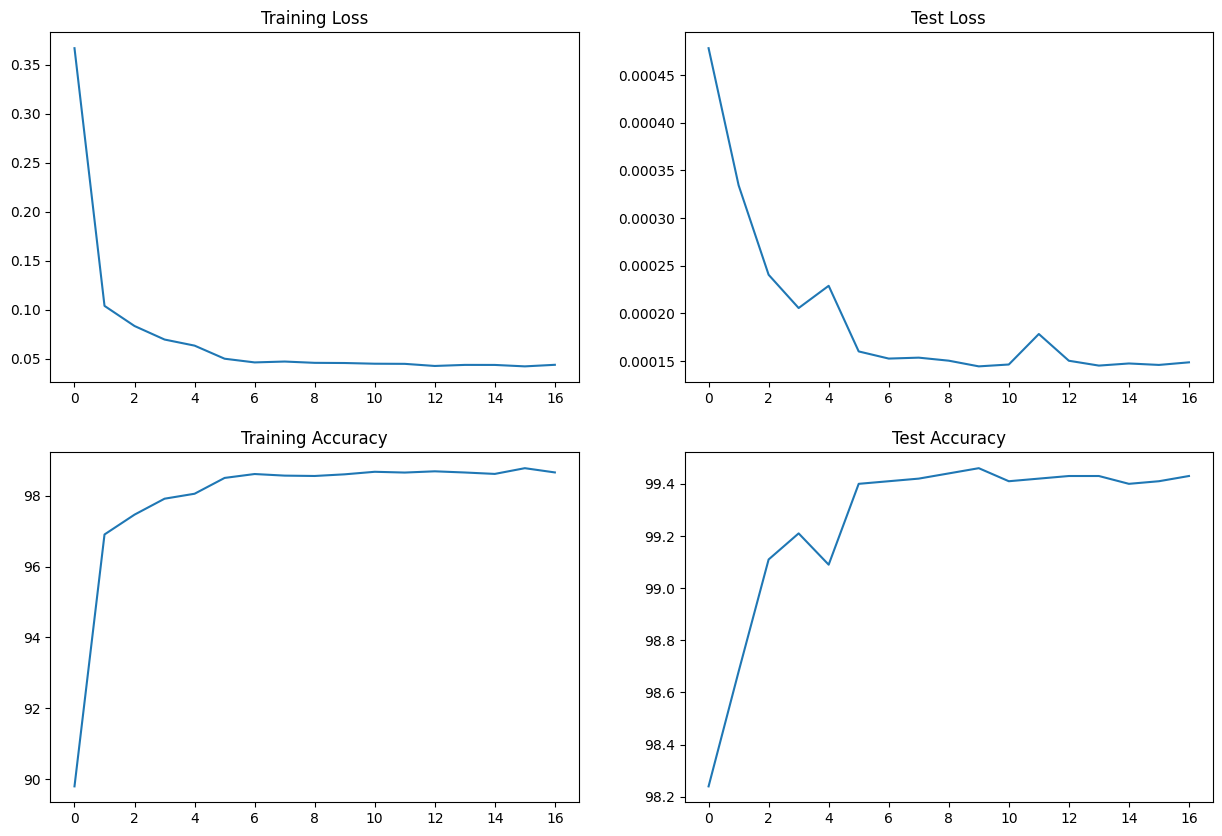

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")